# **Life Expectancy and Population-level Predictors**

## DATA601 Group Project

### L03 Fall 2021

#### Jordan Swanson, Sallene Wong, Alberto Ávila Garcia (*The Dream Team*)
 
&nbsp;\
&nbsp;\
&nbsp;\
&nbsp;\
&nbsp;\
&nbsp;\
&nbsp;

## Introduction

Public interest in health data is at an all-time high as the world continues to navigate the COVID-19 pandemic. Though population-level data has been collected and analyzed for decades, the availability of both high-quality data and easily accessible tools for analysis has removed many of the barriers and allowed for more casual examination of the data. Many metrics are available that can describe how healthy a population is, but unfortunately there are relatively few as widely available as life expectancy. Though efforts have been made to promote indicators that have take into account more than just years lived (Stiefel, 2010), life expectancy continues to be a valuable measurement of overall population health. In our report, we will use the tools and data available to investigate the relationships between many different available measures of both population and health data, and identify the indicators that have the largest effect on life expectancy.

## Guiding Questions

There are several avenues of interest that we'd like to explore:

**1. Is there a correlation between gross domestic product (GDP) and mean years of schooling?** \
    It should stand to reason that countries with greater economic power (as measured by GDP per capita) have the abiliy to afford to better educate their populations. This relationship may be two-way; an educated populace may be capable of greater economic output.
    
**2. If a correlation exists between GDP and mean years of schooling, do both correlate with life expectancy?** \
    Lack of health education and lack of means to access healthcare may lower a country's life expectancy.
    
**3. Does body mass index (BMI) correlate with life expectancy?** \
    In the Western world, higher average BMI (i.e. overweight) is generally a larger health threat (Bhaskaran, 2018), though in many other developing parts of the world, lower BMI (i.e. underweight) carries significant health risk.
    
**4. How do these trends change over time?** \
    With the availability of the data over a period of time, can we establish a temporal trend in the data and speculate on causation?

## Dataset

The motivation for this project was the availability of collected health data from an open Kaggle challenge (Rajarshi, 2018). Unfortunately, upon further analysis it was determined that the quality of data available on the Kaggle page was very low quality and contained many errors. Still wanting to pursue the questions that we formulated around the data, we were able to follow the Kaggle challenge's sources for the data, and went to the original source and retrieved the raw data(GHO, 2018; World Bank, 2021; United Nations, 2020). A more detailed breakdown of the data sources is included in Appendix A, along with their licenses.

All the data was available for retrieval in a tabular comma-separated value format from the respective websites. Having such structured data made the process of cleaning considerably simpler, though it was not without its challenges, as each website had a slightly different format for their files. Despite the data being sourced from multiple locations, the theme remains the same for all the datasets. We're investigating many different factors of population-level health, demographic, and economic data. Throughout the document here, we've referred to datasets with logical names, but below is a data dictionary that will help further describe the features and their units of measure:

**Country**
- Common name of country of interest

**Year**
- Calendar year of data collection

**Status**
- UN classification of a "developed" vs "developing" country 
- Human Development Index score of > 0.800 = "Developed"; < 0.800 = "Developing"

**Adult Mortality**
- Rate of both sexes' probability of dying between 15 and 60 years of age (per 1000 population)

**Health Expenditure**
- Expenditure on health as a percentage of GDP (per capita)

**Body Mass Index (BMI)**
- Average body mass index of the population (both sexes) in kg/m^2

**Gross Domestic Product (GDP)**
- Gross domestic product of a country (in 2019 USD)

**Life Expectancy**
- Life expectancy at birth, total years (both sexes)

**Population**
- Total population of a country

**Schooling**
- Average number of years of education received by people ages 25 and older, converted from education attainment levels using official durations of each level




*Assumptions*
- For many of our datasets, measurements were available for both males and females. In an effort to remain within the scope of this project, we chose to select data for both sexes, where necessary.
- The bulk of our data spans the years 2000-2016. During that time, many boundaries were redrawn and countries either ceased to exist, or were split off of existing ones. Due to the complications of accounting for these differences, countries meeting either of the above criteria were excluded.



## Data wrangling

In [2]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import plotly as py
import plotly.express as px
import plotly.graph_objects as go
import math as m

In [ ]:
## Importing the individual datasets for cleaning, and preparing for consolidation. 

## Adult mortality
adult_mortality_data = pd.read_csv("Adult Mortality.csv",usecols=
                                   ["Year", "Country", "Sex", "Numeric"])
adult_mortality_data = adult_mortality_data[adult_mortality_data.Sex ==
                                            "Both sexes"]
adult_mortality_data = adult_mortality_data.rename(
    columns={"Numeric":"Adult Mortality"}).drop(["Sex"],axis=1)

## BMI
BMI_data = pd.read_csv("BMI.csv",usecols=["Year", "Country", "Numeric"],nrows=8022)
BMI_data = BMI_data.rename(columns={"Numeric":"BMI"})
BMI_data = BMI_data.drop(BMI_data[BMI_data.Year < 2000].index).reset_index(drop=True)

## Country status
country_status_data = pd.read_csv("Country Status.csv")
country_status_data["Status"] = ["Developed" if x >= 0.800 else "Developing"
                                 for x in country_status_data["hdi2019"]]
country_status_data = country_status_data.drop(["pop2021","hdi2019"],axis=1)
country_status_data = country_status_data.rename(columns=
                                                 {"country":"Country"})
country_status_data = country_status_data.sort_values(
    "Country").reset_index(drop=True)
    
## Per capita health expenditure
per_capita_health_exp_data = pd.read_csv(
    "Expenditure on health as a percentage of Gross Domestic Product per capita(%).csv",
    usecols=["Year", "Country", "Numeric"])
per_capita_health_exp_data = per_capita_health_exp_data.rename(
    columns={"Numeric":"Per capita health expenditure as a % of GDP per capita"})
per_capita_health_exp_data = per_capita_health_exp_data.sort_values(
    ["Country","Year"]).reset_index(drop=True)
    
## GDP
gdp_data = pd.read_csv("GDP.csv",header=2,usecols=[0,*range(44,61)])
gdp_data = gdp_data.melt(id_vars="Country Name",
                         var_name="Year",
                         value_name="GDP per capita (USD)").sort_values(
                             ["Country Name", "Year"]).reset_index(drop=True)
gdp_data = gdp_data.rename(columns={"Country Name":"Country"})
        
## Life Expectancy
life_expectancy_data = pd.read_csv("life-expectancy-at-birth-total-years.csv",
                                   usecols=["Entity",
                                            "Life expectancy at birth, total (years)",
                                            "Year"])
life_expectancy_data = life_expectancy_data.rename(
    columns={"Entity": "Country", "Life expectancy at birth, total (years)":
             "Life expectancy at birth"})

## Schooling
schooling_data = pd.read_csv("Mean years of schooling (years).csv",
                              header=5,
                              skipfooter=29,
                              encoding="latin1"
                              ,engine="python")
schooling_data = schooling_data.drop(schooling_data.iloc[:,3::2],axis=1).drop(
    "HDI Rank",axis=1)
schooling_data = schooling_data.melt(id_vars="Country",
                          var_name="Year",
                          value_name="Mean years of schooling")
schooling_data["Year"] = schooling_data["Year"].astype(int)
schooling_data = schooling_data.drop(
    schooling_data[schooling_data["Mean years of schooling"] == ".."].index)
schooling_data = schooling_data.drop(
    schooling_data[schooling_data["Year"] < 2000].index)
schooling_data = schooling_data.sort_values(
                              ["Country", "Year"]).reset_index(drop=True)

## Population
population_data = pd.read_csv("Population.csv",
                              header=2,usecols=[0,*range(44,61)])
population_data = population_data.melt(id_vars="Country Name",
                         var_name="Year",
                         value_name="Population").sort_values(
                             ["Country Name", "Year"]).reset_index(drop=True)
population_data = population_data.rename(columns={"Country Name":"Country"})

## Miscellaneous cleaning
# Drop NaN values from GDP, Population, and Schooling data
gdp_data = gdp_data.dropna(axis=0, how="any")
population_data = population_data.dropna(axis=0, how="any")
schooling_data = schooling_data.dropna(axis=0, how="any")

# Strip whitespace from Schooling country names
schooling_data["Country"] = schooling_data["Country"].str.strip()

# Convert columns to int to merge with master
gdp_data["Year"] = gdp_data["Year"].astype(float).astype("Int64")
population_data["Year"] = population_data["Year"].astype(float).astype("Int64")
schooling_data["Mean years of schooling"] = schooling_data[
    "Mean years of schooling"].astype(float)

# Consolidate data
master_data = BMI_data.merge(adult_mortality_data,how="left")
master_data = master_data.merge(country_status_data,how="left")
master_data = master_data.merge(per_capita_health_exp_data,how="left")
master_data = master_data.merge(life_expectancy_data,how="left")
master_data = master_data.merge(population_data,on=["Country","Year"], how="left")
master_data = master_data.merge(gdp_data,how="left")
master_data = master_data.merge(schooling_data,how="left")
codes = pd.read_csv('country_codes.csv')
master_data = pd.merge(master_data, codes[['Country','Code']], on='Country', how='left').round(2)

# Write to CSV
master_data.to_csv("./master_data.csv", index=False)

## Analysis and visualization

In [3]:
df = pd.read_csv('master_data.csv').rename(
    {'Per capita health expenditure as a % of GDP per capita':'Health expenditure'}, axis=1)

variables = ['BMI', 'Adult Mortality', 'Health expenditure', 'Life expectancy at birth', 
            'Population', 'GDP per capita (USD)', 'Mean years of schooling']

years = list(range(2000,2017))

df.head()

,Year,Country,BMI,Adult Mortality,Status,Health expenditure,Life expectancy at birth,Population,GDP per capita (USD),Mean years of schooling,Code
0,2000,Afghanistan,21.5,316.05,Developing,NaN,55.84,20779957,NaN,2.2,AFG
1,2001,Afghanistan,21.6,307.24,Developing,NaN,56.31,21606992,NaN,2.2,AFG
2,2002,Afghanistan,21.7,292.34,Developing,8.99,56.78,22600774,179.43,2.3,AFG
3,2003,Afghanistan,21.8,286.46,Developing,5.58,57.27,23680871,190.68,2.4,AFG
4,2004,Afghanistan,21.9,281.89,Developing,6.98,57.77,24726689,211.38,2.5,AFG


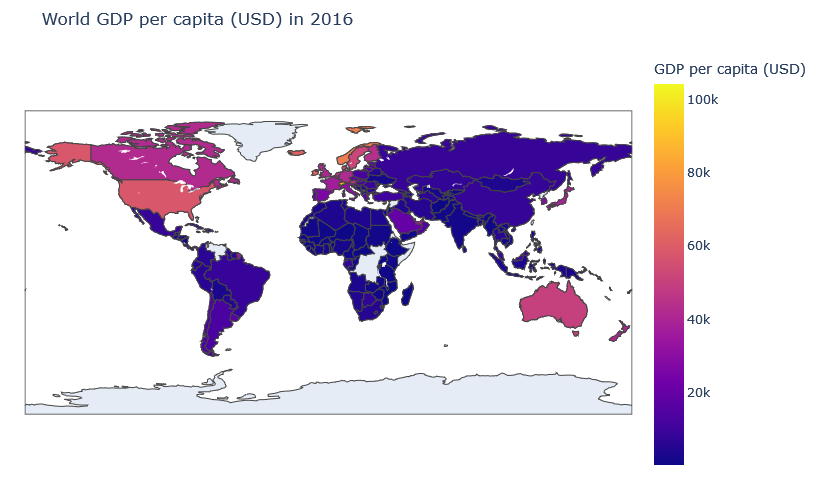

In [7]:
def choropleth(Y, col):
    h, w = 500, 1000
    plot_title = 'World {} in {}'.format(col, Y)
    
    fig = px.choropleth(df[df.Year == Y],
        locations='Code',
        color=col,
        hover_name='Country',
        title=plot_title,
        color_continuous_scale='Plasma',
        height=h,
        width=w
        )
    fig.update_layout(margin=dict(t=50, l=25, r=25, b=25))
    # py.io.write_image(fig, './imgs/world_map/' + plot_title + '.png', format='png', width=w, height=h, scale=3)
    fig.show()

choropleth(2016, 'GDP per capita (USD)')

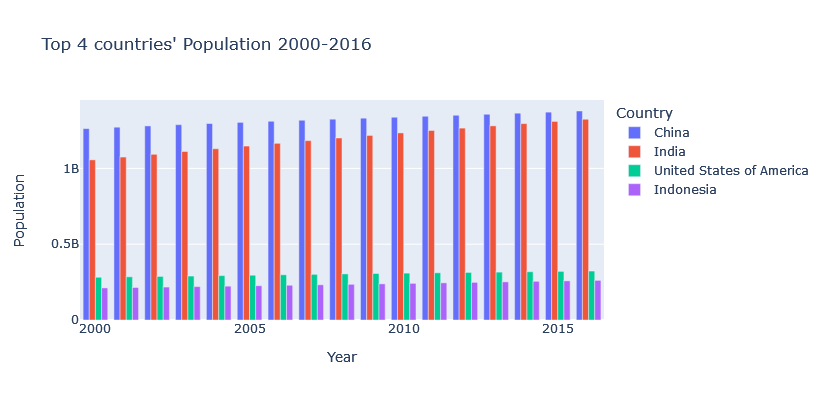

In [5]:
def get_top_n(col, maximum, n, df=df):
    h, w = 400, 1000
    plot_title = "Top {} countries' {} 2000-2016".format(n,col)
    df = df[['Year','Country',col]]\
        .sort_values(['Year',col], ascending=not maximum)\
            .groupby('Year').head(n)

    fig = px.bar(df, x='Year', y=col, color='Country', barmode='group',
        title=plot_title,
        height=h,
        width=w
        )
    # py.io.write_image(fig, './imgs/top/' + plot_title + '.png', format='png', width=w, height=h, scale=3)
    fig.show()

get_top_n('Population', True, 4)

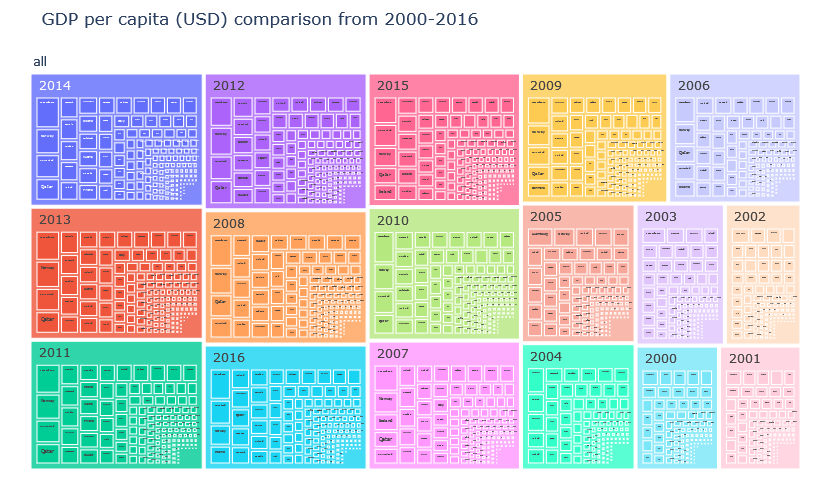

In [8]:
def tree_map(col):
    h, w = 500, 1200
    plot_title = '{} comparison from 2000-2016'.format(col)
    fig = px.treemap(
        df, values=col,
        path=[px.Constant("all"), 'Year', 'Country'],
        title=plot_title,
        height=h,
        width=w
    )
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    # py.io.write_image(fig, './imgs/tree/' + plot_title + '.png', format='png', width=w, height=h, scale=3)
    fig.show()

tree_map('GDP per capita (USD)')

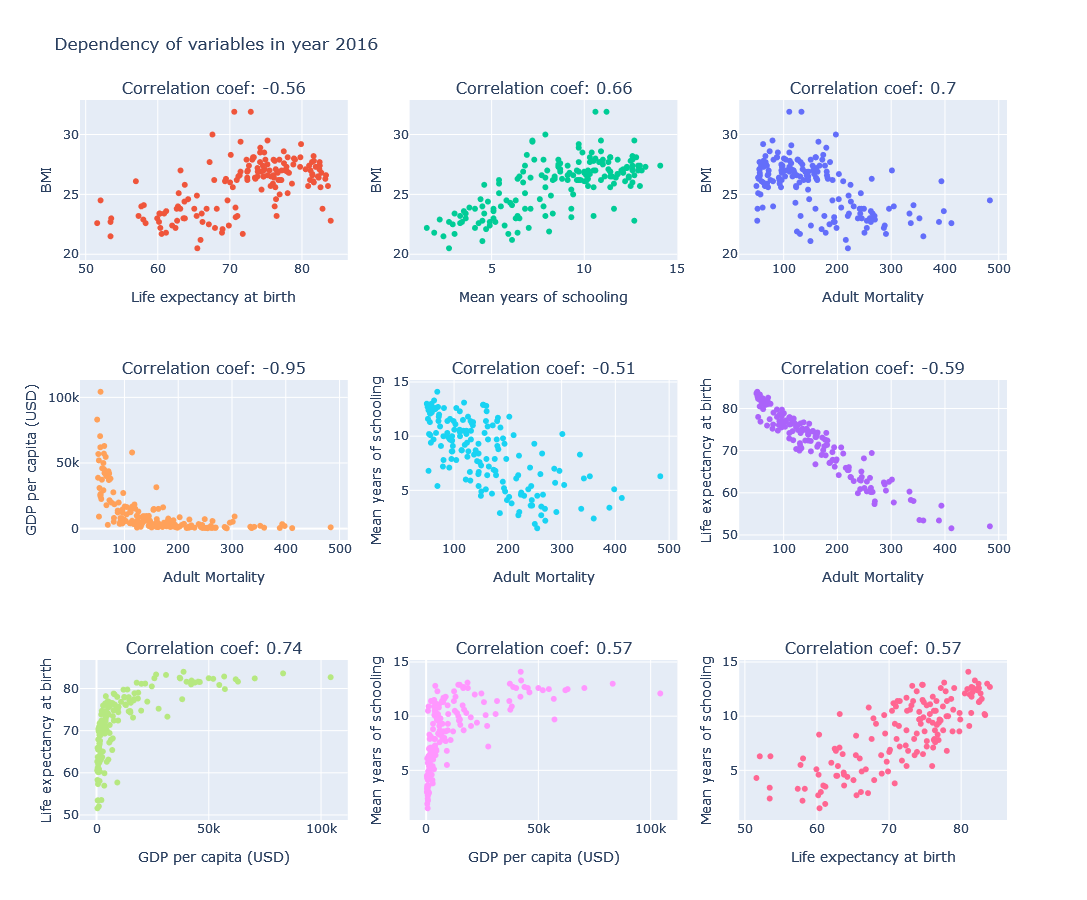

In [9]:
def dependency(y, df=df):
    x_data = ['Adult Mortality', 'Life expectancy at birth', 'Mean years of schooling', 'Adult Mortality',
    'Adult Mortality', 'Adult Mortality', 'Life expectancy at birth','GDP per capita (USD)','GDP per capita (USD)']
    y_data = ['BMI', 'BMI', 'BMI', 'Life expectancy at birth', 'GDP per capita (USD)','Mean years of schooling',
    'Mean years of schooling','Life expectancy at birth','Mean years of schooling']
    titles = ['Correlation coef: ' + str(round(df[x_data[i]].corr(df[y_data[i]]),2)) for i in range(9)]
    plot_title = "Dependency of variables in year {}".format(y)
    h, w = 900, 900

    fig = py.subplots.make_subplots(rows=3, cols=3, subplot_titles=titles)
    df = df[df.Year == y]

    for i in range(9):
        c = i%3
        if i%3 == 0: c = 3
        r = m.ceil((i + 1)/3)
        plot = go.Scatter(x=df[x_data[i]], y=df[y_data[i]], mode='markers')
        fig.add_trace(plot, row = r, col = c)
        fig.update_xaxes(title_text=x_data[i], row=r, col=c)
        fig.update_yaxes(title_text=y_data[i], row=r, col=c, title_standoff = 0.1)

    fig.update_layout(height=h, width=w,
        showlegend=False,
        title_text=plot_title)

    # py.io.write_image(fig, './imgs/coeff/' + plot_title + '.png', format='png', width=w, height=h, scale=3)
    fig.show()

dependency(2016)

### Conclusion

### Appendix A
Specific sources for data and licenses:

Adult mortality, https://apps.who.int/gho/data/view.main.1360 
- https://creativecommons.org/licenses/by-nc-sa/3.0/igo/

Body Mass Index (BMI), https://apps.who.int/gho/data/view.main.BMIMEANADULTCv 
- https://creativecommons.org/licenses/by-nc-sa/3.0/igo/

General government expenditure on health as a percentage of total government expenditure (%), https://apps.who.int/gho/data/view.main.HS05v
- https://creativecommons.org/licenses/by-nc-sa/3.0/igo/

Gross Domestic Product (GDP) USD, https://data.worldbank.org/indicator/NY.GDP.PCAP.CD
- https://creativecommons.org/licenses/by/4.0/

Human Development Index (HDI), http://hdr.undp.org/en/indicators/137506
- https://creativecommons.org/licenses/by/3.0/igo/

Life expectancy at birth, total years, https://databank.worldbank.org/reports.aspx?dsid=2&series=SP.DYN.LE00.IN
- https://creativecommons.org/licenses/by/4.0/

Mean years of schooling, http://hdr.undp.org/en/indicators/103006
- https://creativecommons.org/licenses/by/3.0/igo/

Population, https://data.worldbank.org/indicator/SP.POP.TOTL
- https://creativecommons.org/licenses/by/4.0/

### References

Bhaskaran, K., dos-Santos-Silva, I., Leon, D. A., Douglas, I. J., & Smeeth ,L. (2018). Association of BMI with overall and cause specific mortality: a population-based cohort study of 3·6 million adults in the UK. *The Lancet Diabetes & Endocrinology, (6)* 12, 944-953, https://doi.org/10.1016/S2213-8587(18)30288-2

Global Health Observatory Data Repository (2018), *Global Health Observatory indicator views*, https://apps.who.int/gho/data/node.imr. Retrieved September 21st, 2021

Rajarshi, K. (2018, February). Life Expectancy (WHO): Statistical Analysis on factors influencing Life Expectancy, Version 1. Retrieved September 21, 2021 from https://www.kaggle.com/kumarajarshi/life-expectancy-who/version/1.

Stiefel, M. C., Perla, R. J., & Zell, B. L. (2010). A healthy bottom line: healthy life expectancy as an outcome measure for health improvement efforts. *The Milbank quarterly, 88* (1), 30–53. https://doi.org/10.1111/j.1468-0009.2010.00588.x

United Nations (2020), *Human Development Report Office*, http://hdr.undp.org/en/data. Retrieved October 6th, 2021 

World Bank (2021, September), *World Development Indicators*, https://datacatalog.worldbank.org/search/dataset/0037712. Retrieved October 6th, 2021